In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [3]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Toy Diffusion

## 1. Get Data

We will be using the MNIST dataset.

In [4]:
# Download the MNIST dataset
mnist_dataset = datasets.MNIST(
    root = "data/",
    train = True,
    download = True,
    transform = ToTensor()
)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.72MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
# Create dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size = 8, shuffle = True)

In [6]:
# Check first batch of train dataloader
images, labels = next(iter(train_dataloader))

Input shape is: torch.Size([8, 1, 28, 28]) [batch, channels, height, width]
Labels are: tensor([6, 0, 3, 6, 2, 9, 9, 7])


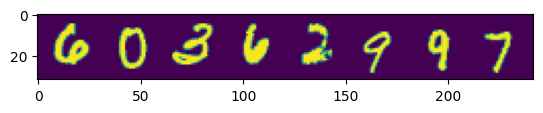

In [7]:
# Check first batch of train dataloader
print(f"Input shape is: {images.shape} [batch, channels, height, width]")
print(f"Labels are: {labels}")

# Make grid will create 3 channels, we use indexing to only use the first
plt.imshow(make_grid(images)[0])
plt.show()


## 2. The Model

### The Corruption Process

The process of adding noise to images is usually called corruption. The corruption process consists of the following steps:
* first create a random tensor with shape matching the shape of the images
* then we pick an amount for the noise to add which we will call  $α$
* finnally, we scale the original clean image by a factor of $1 - α$ and add $α$ times the noise to it
$$noised\_image = (1 - noise\_amount)
  clean\_image + (noise\_amount)pure\_noise$$
<br>
$$
x_{\text{noised}} = (1 - \alpha)x + \alpha \xi, \quad \xi \sim \mathcal{N}(0, 1), \quad \alpha \sim \mathcal{N}(0, 1)
$$

In [8]:
def corrupt(x, noise_amount):
    # Create a random tensor matching the shape of x
    noise = torch.rand_like(x)
    # Adjust shape so broadcasting will work(requires either identical or smaller having shape of (1,))
    noise_amount = noise_amount.view(-1, 1, 1, 1)
    return (1 - noise_amount) * x + noise_amount * noise

In [9]:
# Example of adjusting the shape of the noise amount
# Assume batch of 8 images
image_shape_0 = 8
# Create linearly spaced amounts and reshape them
amount = torch.linspace(0, 1, image_shape_0).view(-1, 1, 1, 1)
print(amount.shape)
amount

torch.Size([8, 1, 1, 1])


tensor([[[[0.0000]]],


        [[[0.1429]]],


        [[[0.2857]]],


        [[[0.4286]]],


        [[[0.5714]]],


        [[[0.7143]]],


        [[[0.8571]]],


        [[[1.0000]]]])

### Visualization of the corruption process

In [10]:
# Create noisy versions of first batch of training data
noise_amount = torch.linspace(0, 1, images.shape[0])
noised_images = corrupt(images, noise_amount)

[]

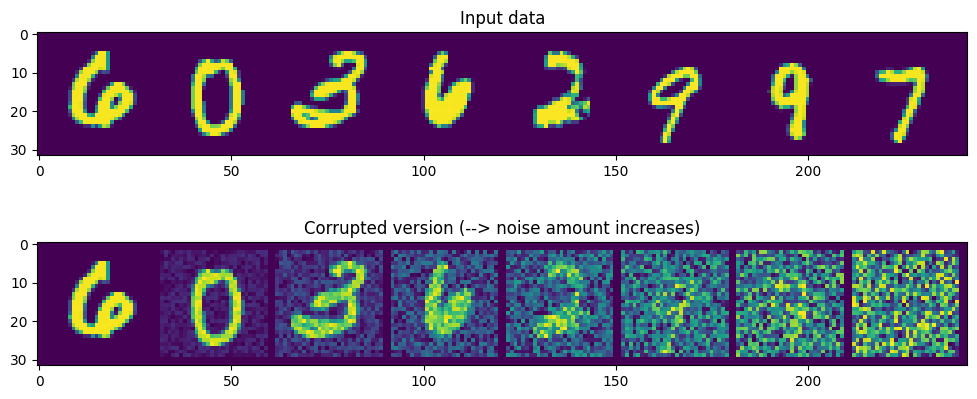

In [11]:
# Plot input data
fix, axs = plt.subplots(2, 1, figsize = (12, 5))
axs[0].set_title("Input data")
axs[0].imshow(make_grid(images)[0])

# Plot corrupted data
axs[1].set_title("Corrupted version (--> noise amount increases)")
axs[1].imshow(make_grid(noised_images)[0])
plt.plot()

### Model Architecture

For diffusion, the main model architecture is either a U-net or a transformer. Here we will use a very basic version of the former. The U-net architecture was originally invented for the task of segmentation of medical imagery - like microscopic images of tissues, where the task is to segmet both the different types of cell and different instances of the same cell type.
The U-net can be viewed as a type of Autoencoder or as a convolutional network and its reflection connected in the middle. It has a downsample path, a bottleneck and a upsample path. In the downsample path the inputs' spatial dimensions(height, width) are decreased while channel dimensions are increased. The upsample path reverses this - spatial dimensions are increased, while channel dimension are decreased.
A very importtant feature of the U-net architecture is the fact that there are residual connection between levels of the upsample and downsample path where the spatial dimensions match.

For diffusion tasks, the primary model architecture is typically a U-Net or a transformer. In this context, we will focus on a very basic version of the U-Net.

The U-Net architecture was originally developed for segmentation tasks in medical imagery. For example, it was designed to segment:
* Different types of cells in microscopic images of tissues.
* Different instances of the same cell type.

The U-Net can be thought of as:
* A type of autoencoder.
* A convolutional network paired with its reflection, connected in the middle.

It consists of three main components:

1. Downsample Path:
Reduces the spatial dimensions (height and width) of the input.
Increases the number of channels.
2. Bottleneck:
Serves as the transition point between the downsample and upsample paths.
3. Upsample Path:
Reverses the downsample path.
Increases the spatial dimensions while decreasing the number of channels.


A key feature of the U-Net architecture is the residual connections between the corresponding levels of the downsample and upsample paths. These connections link layers where the spatial dimensions match, allowing the model to reuse features from the downsample path in the upsample path.

In [12]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels = 1,
                 out_channels = 1,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1):
        super().__init__()
        # Downsample layers
        self.down_conv1 = nn.Conv2d(in_channels = in_channels,
                                    out_channels = 32,
                                    kernel_size= kernel_size,
                                    stride = stride,
                                    padding = padding)
        self.down_conv2 = nn.Conv2d(in_channels = 32,
                                    out_channels = 32,
                                    kernel_size= kernel_size,
                                    stride = stride,
                                    padding = padding)
        self.down_conv3 = nn.Conv2d(in_channels = 32,
                                    out_channels = 64,
                                    kernel_size= kernel_size,
                                    stride = stride,
                                    padding = padding)
        self.down_conv4 = nn.Conv2d(in_channels = 64,
                                    out_channels = 64,
                                    kernel_size= kernel_size,
                                    stride = stride,
                                    padding = padding)
        self.down_conv5 = nn.Conv2d(in_channels = 64,
                                    out_channels = 64,
                                    kernel_size = kernel_size,
                                    stride = stride,
                                    padding = padding)

        # Upsample layers
        self.up_conv1 = nn.Conv2d(in_channels = 64,
                                  out_channels = 64,
                                  kernel_size= kernel_size,
                                  stride = stride,
                                  padding = padding)
        self.up_conv2 = nn.Conv2d(in_channels = 64,
                                  out_channels = 64,
                                  kernel_size= kernel_size,
                                  stride = stride,
                                  padding = padding)
        self.up_conv3 = nn.Conv2d(in_channels = 64,
                                  out_channels = 32,
                                  kernel_size= kernel_size,
                                  stride = stride,
                                  padding = padding)
        self.up_conv4 = nn.Conv2d(in_channels = 32,
                                  out_channels = 32,
                                  kernel_size= kernel_size,
                                  stride = stride,
                                  padding = padding)
        self.up_conv5 = nn.Conv2d(in_channels = 32,
                                  out_channels = 1,
                                  kernel_size= kernel_size,
                                  stride = stride,
                                  padding = padding)

        # Activation function
        self.act = nn.SiLU()
        # Downscale (pooling)
        self.downscale = nn.MaxPool2d(kernel_size = 2)
        # Upscale (upsampling)
        self.upscale = nn.Upsample(scale_factor = 2)

    def forward(self, x):
        # Downward path (encoding)
        x1_down = self.act(self.down_conv1(x))
        x2_down = self.act(self.down_conv2(x1_down))

        x2_down_pool = self.downscale(x2_down)

        x3_down = self.act(self.down_conv3(x2_down_pool))
        x4_down = self.act(self.down_conv4(x3_down))

        x4_down_pool = self.downscale(x4_down)

        x_latent = self.act(self.down_conv5(x4_down_pool))

        # Upward path (decoding)
        x4_up = self.act(self.up_conv1(x_latent))

        x4_up_Unpool = self.upscale(x4_up)

        # Inner Residual connection
        x4_up_Unpool_res = x4_up_Unpool + x4_down

        x3_up = self.act(self.up_conv2(x4_up_Unpool_res))
        x2_up = self.act(self.up_conv3(x3_up))

        x2_up_unpool = self.upscale(x2_up)

        # Outer residual connection
        x2_up_res = x2_up_unpool + x2_down

        x1_up = self.act(self.up_conv4(x2_up_res))

        # Final output layer
        output = self.act(self.up_conv5(x1_up))
        return output

In [13]:
# Test model with dummy input
denoiser = BasicUNet(in_channels = 1, out_channels = 1)
dummy_input = torch.randn(1, 1, 28, 28)
output = denoiser(dummy_input)

In [14]:
# Check model summary
summary(model = denoiser, input_data = dummy_input, depth = 3, device = "cpu")

Layer (type:depth-idx)                   Output Shape              Param #
BasicUNet                                [1, 1, 28, 28]            --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─SiLU: 1-2                              [1, 32, 28, 28]           --
├─Conv2d: 1-3                            [1, 32, 28, 28]           9,248
├─SiLU: 1-4                              [1, 32, 28, 28]           --
├─MaxPool2d: 1-5                         [1, 32, 14, 14]           --
├─Conv2d: 1-6                            [1, 64, 14, 14]           18,496
├─SiLU: 1-7                              [1, 64, 14, 14]           --
├─Conv2d: 1-8                            [1, 64, 14, 14]           36,928
├─SiLU: 1-9                              [1, 64, 14, 14]           --
├─MaxPool2d: 1-10                        [1, 64, 7, 7]             --
├─Conv2d: 1-11                           [1, 64, 7, 7]             36,928
├─SiLU: 1-12                             [1, 64, 7, 7]             --

In [15]:
sum([p.numel() for p in denoiser.parameters()])

203777

## 3. Training

The training process consists of the following steps:
* Take a batch of images from the training set
* Corrupt each image by random amount
* Feed corrupted images to the Unet model and have the model predict their clean (uncorrupted) versions
* Compare the predictions with the ground truth clean images to calculate the loss
* Updata the model parameters to minimizer the loss


In [16]:
# Set batch size
batch_size = 128
# Create train dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle = True)

# Create model instance and send it to device
denoiser = BasicUNet().to(device)

# Set loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(denoiser.parameters(), lr = 1e-3)

# Set epochs
epochs = 10

# Create a list to track loss
losses = []

In [17]:
# Training
for epoch in range(epochs):
    for x, _ in train_dataloader:

        # Corrupt data
        x = x.to(device) # move data to device
        noise_amount = torch.randn(x.shape[0]).to(device)
        noised_x = corrupt(x, noise_amount)

        # Forward pass
        prediction = denoiser(noised_x)

        # Calculate loss
        loss = loss_fn(prediction, x)

        # Zero the gradient
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # Updata parameters
        optimizer.step()

        # Store loss value
        losses.append(loss.item())

    # Print average loss value for the epoch
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch: {epoch + 1}. Average loss for this epoch: {avg_loss:05f}")

Epoch: 1. Average loss for this epoch: 0.021126
Epoch: 2. Average loss for this epoch: 0.011564
Epoch: 3. Average loss for this epoch: 0.010084
Epoch: 4. Average loss for this epoch: 0.009330
Epoch: 5. Average loss for this epoch: 0.008852
Epoch: 6. Average loss for this epoch: 0.008589
Epoch: 7. Average loss for this epoch: 0.008390
Epoch: 8. Average loss for this epoch: 0.008052
Epoch: 9. Average loss for this epoch: 0.007852
Epoch: 10. Average loss for this epoch: 0.007771


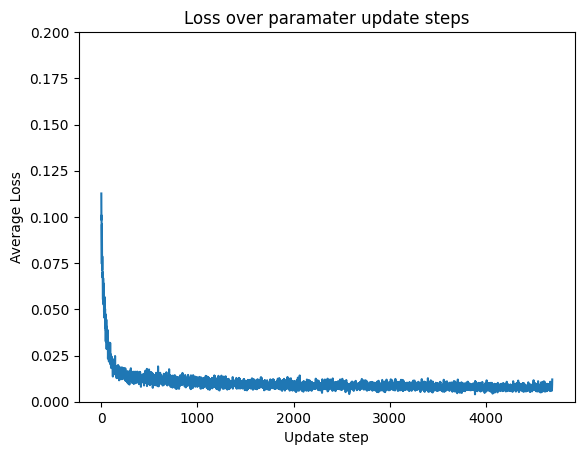

In [18]:
# Plot loss curve
plt.plot(range(len(losses)), losses)
plt.ylim(0, 0.2)
plt.ylabel("Average Loss")
plt.xlabel("Update step")
plt.title("Loss over paramater update steps")
plt.show()

Below we visualize the predictions of the trained model. We will add progressively more noise to check what the model performance is for different levels of corruption.

In [19]:
# Get some data
x, _ = next(iter(train_dataloader))
x = x[:8]

# Corrupt data
noise_amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, noise_amount)

# Get model predictions
denoiser.eval()
with torch.inference_mode():
    predictions = denoiser(noised_x.to(device))
    preds_for_plotting = predictions.detach().cpu()

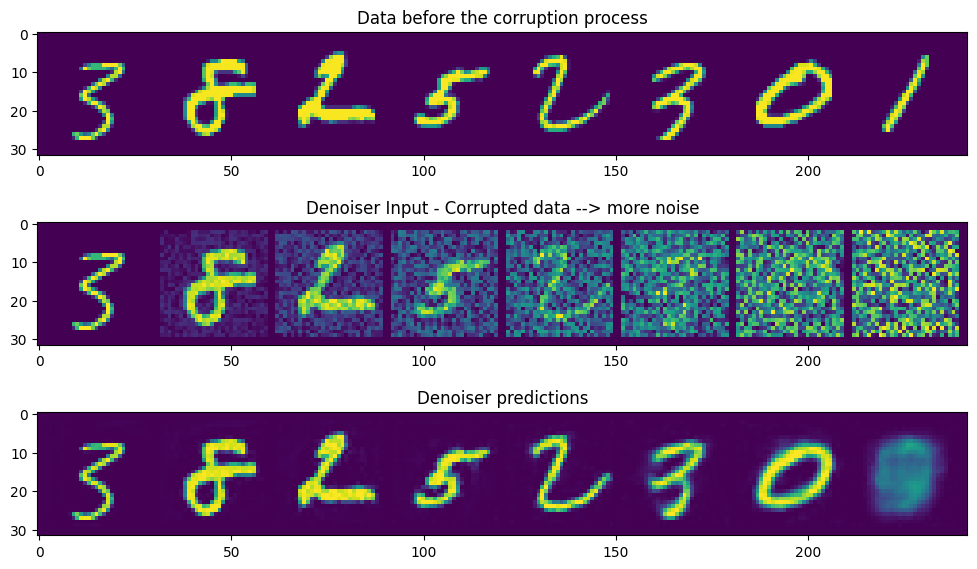

In [20]:
# Visualize predictions of trained model
fig, axs = plt.subplots(3, 1, figsize = (12, 7))
axs[0].set_title("Data before the corruption process")
axs[0].imshow(make_grid(x)[0].clip(0, 1))
axs[1].set_title("Denoiser Input - Corrupted data --> more noise")
axs[1].imshow(make_grid(noised_x)[0].clip(0, 1))
axs[2].set_title("Denoiser predictions")
axs[2].imshow(make_grid(preds_for_plotting)[0].clip(0, 1))
plt.show()

When the noise level is low the denoiser does pretty well, however when the image is mostly or only noise the predictions is a blurry mess which is probably close to the mean of the dataset.

## 4. Sampling

Once we have a trained denoiser we would ideally like to sample with it. That is start from a vector of pure noise and produce a realistic image, that could have come from the original dataset. However, as we saw the current denoiser doesn't doo too well when the image is very noisy. To combat this we will need a sampling strategy.

One such strategy is to use the model predictions, but only move a small amount towards the clean image and repeat this many times. Since we now the denoiser performs better with less noisy inputs, we will increase the size of the step towards the clean image as we progress. Essentially, we will make smaller steps at the start and larger and larger stpes towards the end. The hope is that each step in this iterative process will produce more and more structure in ouput and we will eventually arrive at a clean image.

Another benefit of this idea is that the model will make different errors in each iteration and over the whole process the errors will average out and only the true trajectory from pure noise to clea image will remain. The downside, of course is that we can no longer get a clean image in one forward pass, but we are stuck with a potentially computationally expensive iterative process.

In [21]:
def sample(denoiser, n_steps = 5, n_samples = 8):
    """
    Implements a basic strategy to sample with a denoiser,
    increasing the adjustment to the input at each step.
    """
    # Create a tensor of pure noise
    x = torch.rand(n_samples, 1, 28, 28).to(device)
    # List to store inputs at each step
    input_history = [x.detach().cpu()]
    # List to store  at each step
    output_history = []

    # Variable to control changes for each step
    step_size = None

    # Sampling
    for i in range(n_steps):
        denoiser.eval()
        with torch.inference_mode():
            predictions = denoiser(x)
        output_history.append(predictions.detach().cpu())
        step_size = 1 / (n_steps - i)
        # Denoising
        x = x * (1 - step_size) + predictions * step_size
        input_history.append(x.detach().cpu())

    return input_history, output_history

def visualize_denoising_process(input_history, output_history):
    """
    Visualize the denoising process by showing inputs and denoised inputs at
    each step.
    """
    n_steps = len(output_history)
    fix, axs = plt.subplots(n_steps, 2, figsize = (9, 4), sharex = True)
    axs[0, 0].set_title("denoiser input")
    axs[0, 1].set_title("denoiser predictions")
    for i in range(n_steps):
        axs[i, 0].imshow(make_grid(input_history[i])[0].clip(0, 1))
        axs[i, 1].imshow(make_grid(output_history[i])[0].clip(0, 1))

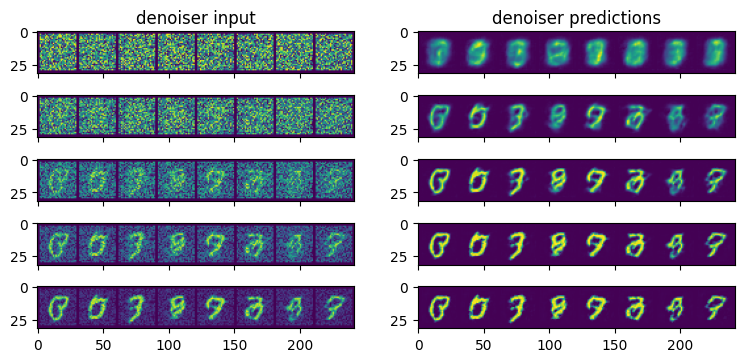

In [38]:
# Results with 5 steps
input_history, output_history = sample(denoiser = denoiser, n_steps = 5)
visualize_denoising_process(input_history, output_history)

In [39]:
# Results with 20 steps
_, output_history = sample(denoiser = denoiser, n_steps = 20)

In [40]:
ouputs = torch.cat(output_history, dim = 0)

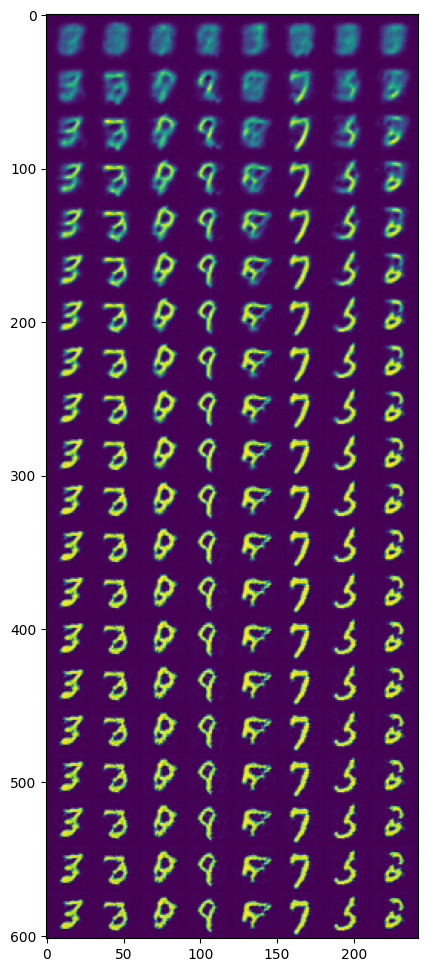

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (36, 12))
ax.imshow(torchvision.utils.make_grid(ouputs, nrow=8)[0].clip(0, 1))
plt.show()